In [ ]:
import torch
import torch.nn as nn
import torchvision
import os
import pandas as pd
import spacy
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
from torchvision.models.feature_extraction import create_feature_extractor, get_graph_node_names
from tqdm.notebook import tqdm, trange
import numpy as np

spacy_eng = spacy.load('en')

In [ ]:
# Feature Extractor - Reteaua Neuronala Convolutionala Inception_v3 care extrage features de dimensiunea 2048x8x8 -> 64x2048, features care vor fi
# utilizate pentru antrena encoderul de CNN si RNN-ul care face captioning
class FeatureExtractorCNN(nn.Module):
    def __init__(self):
        super(FeatureExtractorCNN, self).__init__()
        self.extractor = torchvision.models.inception_v3(pretrained=True)
        self.features_layer = create_feature_extractor(self.extractor, ['avgpool'])

    def forward(self, x):
        self.extractor.eval()
        self.features_layer.eval()
        with torch.no_grad():
            features = self.features_layer(x)
            features = features['avgpool']
            batch_size, channels = features.shape[:2]
            features = features.view(batch_size, channels)
            # print(features.shape)
            return features

In [ ]:
img = torch.rand((1, 3, 299, 299))
fet = FeatureExtractorCNN()
feats = fet(img)
linear = nn.Linear(in_features=2048, out_features=1000)
print(linear(feats).shape)

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torchvision/models/feature_extraction.py:175: UserWarning: NOTE: The nodes obtained by tracing the model in eval mode are a subsequence of those obtained in train mode. When choosing nodes for feature extraction, you may need to specify output nodes for train and eval mode separately.
  warnings.warn(msg + suggestion_msg)


torch.Size([1, 1000])


In [ ]:
# EncoderCNN - Reteaua Neuronala Convolutionala care utilizeza features-urile extrase din imagini si le transforma in dimensiunea embedding-ului
# si le utilizeaza in continuare in RNN pentru a face caption-ul pentru aceasta
class EncoderCNN(nn.Module):
    def __init__(self, embedding_size):
        super(EncoderCNN, self).__init__()
        self.linear = nn.Linear(in_features=2048, out_features=embedding_size)
        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        features = self.linear(x)
        return self.dropout(self.activation(features))

In [ ]:
# CaptioningRNN - Retea Neuronala Recurenta care utilizeaza features-urile obtinute din imaginea de input si,
# utilizand mai multe layere de LSTM (long short-term memory) selecteaza cele mai potrivite cuvinte care ar
# putea alcatui un caption corect pentru input-ul nostru
class CaptioningRNN(nn.Module):
    def __init__(self, embedding_size, hidden_size, vocabulary_size, layer_number):
        super(CaptioningRNN, self).__init__()
        self.embedding = nn.Embedding(num_embeddings=vocabulary_size, embedding_dim=embedding_size)
        self.lstm = nn.LSTM(embedding_size, hidden_size, layer_number)
        self.fc = nn.Linear(in_features=hidden_size, out_features=vocabulary_size)
        self.dropout = nn.Dropout(0.25)
    
    def forward(self, features, captions):
        embeddings = self.embedding(captions)
        embeddings = self.dropout(embeddings)
        embeddings = torch.cat((features.unsqueeze(0), embeddings), dim=0)
        
        hidden_output, _ = self.lstm(embeddings)
        output = self.fc(hidden_output)
        return output

In [ ]:
# ImageCaptioningNet - Retea Neuronala care combina cele doua tipuri de retele neuronale
# de mai sus - CNN si RNN pentru a crea descrieri pentru pozele noastre
class ImageCaptioningNet(nn.Module):
    def __init__(self, embedding_size, hidden_size, vocabulary_size, layer_number):
        super(ImageCaptioningNet, self).__init__()
        self.feature_extractor_cnn = FeatureExtractorCNN()
        self.encoding_cnn = EncoderCNN(embedding_size)
        self.captioning_rnn = CaptioningRNN(embedding_size, hidden_size, vocabulary_size, layer_number)
    
    def forward(self, images, captions):
        features = self.encoding_cnn(images)
        output = self.captioning_rnn(features, captions)
        return output
    
    def extract_features(self, x):
        with torch.no_grad():
            features = self.feature_extractor_cnn(x)
            return features
    
    def generate_caption(self, image, vocabulary, max_length=50):
        caption = []
        with torch.no_grad():
            out = self.feature_extractor_cnn(image).unsqueeze(0)
            out = self.encoding_cnn(out)
            states = None

            for _ in range(max_length):
                hidden_output, states = self.captioning_rnn.lstm(out, states)
                output = self.captioning_rnn.fc(hidden_output.squeeze(0))
                
                predicted_word = output.argmax(dim=1)
                caption.append(predicted_word.item())
                out = self.captioning_rnn.embedding(predicted_word).unsqueeze(0)

                if vocabulary.idx_str_dict[predicted_word.item()] == "<EOS>":
                    break
        
        words_ans = [vocabulary.idx_str_dict[word_idx] for word_idx in caption]
        return ' '.join(words_ans[1:-1])

# Antrenarea
<br>
Mai intai, descarcam setul de imagini si titluri de pe kaggle si o dezarhivam. Pentru asta, e nevoie de incarcat kaggle.json care contine cheia privata a unui cont kaggle.

In [ ]:
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d aladdinpersson/flickr8kimagescaptions

 98% 1.02G/1.04G [00:07<00:00, 141MB/s]
100% 1.04G/1.04G [00:08<00:00, 138MB/s]


In [ ]:
!unzip flickr8kimagescaptions.zip 

Streaming output truncated to the last 5000 lines.
  inflating: flickr8k/images/2844747252_64567cf14a.jpg  
  inflating: flickr8k/images/2844846111_8c1cbfc75d.jpg  
  inflating: flickr8k/images/2844963839_ff09cdb81f.jpg  
  inflating: flickr8k/images/2845246160_d0d1bbd6f0.jpg  
  inflating: flickr8k/images/2845691057_d4ab89d889.jpg  
  inflating: flickr8k/images/2845845721_d0bc113ff7.jpg  
  inflating: flickr8k/images/2846037553_1a1de50709.jpg  
  inflating: flickr8k/images/2846785268_904c5fcf9f.jpg  
  inflating: flickr8k/images/2846843520_b0e6211478.jpg  
  inflating: flickr8k/images/2847514745_9a35493023.jpg  
  inflating: flickr8k/images/2847615962_c330bded6e.jpg  
  inflating: flickr8k/images/2847859796_4d9cb0d31f.jpg  
  inflating: flickr8k/images/2848266893_9693c66275.jpg  
  inflating: flickr8k/images/2848571082_26454cb981.jpg  
  inflating: flickr8k/images/2848895544_6d06210e9d.jpg  
  inflating: flickr8k/images/2848977044_446a31d86e.jpg  
  inflating: flickr8k/images/28491949

## Pregatirea datelor

Pentru a putea utiliza datele descarcate, e nevoie de normalizat titlurile si mapat la valori numerice. Pentru a face asta, in prealabil vom crea vocabularul tuturor cuvintelor prezente in titlurile de antrenare. Vocabularul va reprezenta o mapare dintre cuvintele tokenizate si indexurile sale. De asemenea, se vor adauga inca 4 "cuvinte" in vocabular:
1. '\<PAD>': token adaugat la sfarsitul titlurilor mai scurte pentru ca toate titlurile din un batch sa aiba acelasi numar de tokenuri;
2. '\<SOS>': tokenul care reprezinta inceputul titlului;
3. '\<EOS>': tokenul care reprezinta sfarsitul titlului;
4. '\<UNK>': tokenul care se pune in locul cuvintelor care nu fac parte din vocabular.

Un token (cuvant) nu va fi adaugat in vocabular daca in toate titlurile acesta se intalneste mai putin de `freq_threshold` ori.



In [ ]:
class Vocabulary:
  def __init__(self, freq_threshold):
    # initializam maparile dintre tokenuri si indexul sau si invers
    # adaugam tokenurile speciale la initializare
    self.idx_str_dict = {0: '<PAD>', 1:'<SOS>', 2:'<EOS>', 3:'<UNK>'}
    self.str_idx_dict = {'<PAD>':0, '<SOS>':1, '<EOS>':2, '<UNK>':3}
    self.freq_threshold = freq_threshold

  def __len__(self):
    return len(self.idx_str_dict)

  @staticmethod
  def tokenizer(text):
    """
    Functie statica care primeste un string care reprezinta o propozitie in engleza
    si returneaza o lista de stringuri care reprezinta tokenizarea acesteea.
    """
    return [token.text.lower() for token in spacy_eng.tokenizer(text)]

  def build_vocabulary(self, sentences):
    """
    sunt parcurse si tokenizate titlurile si sunt pastrate cele care apar mai mult de `freq_threshold` ori
    """
    frequencies = {}
    index = 4
    for sentence in sentences:
      for word in self.tokenizer(sentence):
        if word not in frequencies:
          frequencies[word] = 1
        else:
          frequencies[word] += 1
    
    for word, freq in frequencies.items():
      if freq >= self.freq_threshold:
        self.str_idx_dict[word] = index
        self.idx_str_dict[index] = word
        index += 1

  def normalize(self, text):
    """
    Primeste un titlu pe care il tokenizeaza si returneaza lista tokenilor.
    Tokenurile care nu sunt prezente in vocabular sunt inlocuite cu '<UNK>'
    """
    tokenized_text = self.tokenizer(text)

    return [
      self.str_idx_dict[token] if token in self.str_idx_dict else self.str_idx_dict['<UNK>']
      for token in tokenized_text 
    ]


## Dataset-ul și DataLoader-ul

### Features Extraction

In [ ]:
class ImagesDataset(Dataset):
    def __init__(self, root_dir, captions_file, transform=None):
        self.root_dir = root_dir
        self.dataframe = pd.read_csv(captions_file)
        self.transform = transform
        
        self.images = self.dataframe['image']
        
        self.features_path = root_dir.split("/")[0] + "/features"
        os.makedirs(self.features_path, exist_ok=True)

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        image_path = self.images[index]
        image_id = image_path.split(".")[0]
        image = Image.open(os.path.join(self.root_dir, image_path)).convert('RGB')

        if self.transform is not None:
            image = self.transform(image)

        return image, image_id

In [ ]:
class FeaturesDataset(Dataset):
  def __init__(self, root_dir, captions_file, freq_threshold=5):
    self.root_dir = root_dir
    self.dataframe = pd.read_csv(captions_file)
    
    self.images = self.dataframe['image']
    self.captions = self.dataframe['caption']

    self.vocabulary = Vocabulary(freq_threshold)
    self.vocabulary.build_vocabulary(self.captions.tolist())

  def __len__(self):
    return len(self.dataframe)

  def __getitem__(self, index):
    caption = self.captions[index]
    path = f"{self.images[index].split('.')[0]}.npy"
    features = np.load(os.path.join(self.root_dir, path))
    features = torch.from_numpy(features)

    normalized_caption = [self.vocabulary.str_idx_dict['<SOS>']] # start of sentence
    normalized_caption += self.vocabulary.normalize(caption)
    normalized_caption.append(self.vocabulary.str_idx_dict['<EOS>']) # end of sencence

    return features, torch.tensor(normalized_caption)

In [ ]:
class Collate:
  """
  Clasa care adauga padding la toate titlurile dintr-un batch pentru a le face de aceeasi lungime
  """
  def __init__(self, pad_idx):
    self.pad_idx = pad_idx
    
  def __call__(self, batch):
    features = [feat[0].unsqueeze(0) for feat in batch] # a dimensiune aditionala pentru concatenare
    features = torch.cat(features, dim=0)
    targets = [item[1] for item in batch]
    targets = pad_sequence(targets, batch_first=False, padding_value=self.pad_idx)

    return features, targets

In [ ]:
def get_dataloader(
    root_dir,
    annotation_file,
    batch_size=32,
    shuffle=True, 
    pin_memory=True
):
  """
  Initializeaza un Dataset, completeaza vocabularul si pe baza Datasetului creaza un DataLoader
  """
  dataset = FeaturesDataset(root_dir, annotation_file)
  
  pad_idx = dataset.vocabulary.str_idx_dict['<PAD>']

  dataloader = DataLoader(
      dataset=dataset,
      batch_size=batch_size,
      shuffle=shuffle,
      pin_memory=pin_memory,
      collate_fn=Collate(pad_idx)
  )

  return dataloader, dataset

In [ ]:
!ls 

flickr8k  flickr8kimagescaptions.zip  kaggle.json  sample_data


## Features extraction

In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
transform = transforms.Compose(
    [
      transforms.Resize((330, 330)),
      transforms.CenterCrop((299, 299)),
      transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ] 
)

In [ ]:
dataloader, dataset = get_dataloader(
    root_dir='flickr8k/images',
    annotation_file='flickr8k/captions.txt',
)

embedding_size = 256
hidden_size = 256
vocabulary_size = len(dataset.vocabulary)
layer_number = 1
lr = 5e-4
epochs = 100

model = ImageCaptioningNet(
    embedding_size=embedding_size,
    hidden_size=hidden_size,
    vocabulary_size=vocabulary_size,
    layer_number=layer_number
).to(DEVICE)

/usr/local/lib/python3.7/dist-packages/torchvision/models/feature_extraction.py:175: UserWarning: NOTE: The nodes obtained by tracing the model in eval mode are a subsequence of those obtained in train mode. When choosing nodes for feature extraction, you may need to specify output nodes for train and eval mode separately.
  warnings.warn(msg + suggestion_msg)


Extragem features folosind FeatureExtractorCNN

In [ ]:
images_dataset = ImagesDataset(root_dir='flickr8k/images', captions_file='flickr8k/captions.txt', transform=transform)
images_dataloader = DataLoader(
    dataset=images_dataset,
    batch_size=32,
    pin_memory=True,
)

In [ ]:
features = []
for images, paths in tqdm(images_dataloader):
    images = images.to(DEVICE)
    
    feats = model.extract_features(images)
    feats = feats.cpu()
    
    for feat, path in zip(feats, paths):
        path = f"{images_dataloader.dataset.features_path}/{path}.npy"
        np.save(path, feat.numpy())
    features.append(feats)

features = torch.cat(features, dim=0)

  0%|          | 0/1265 [00:00<?, ?it/s]

In [ ]:
print(features.shape)

torch.Size([40455, 2048])


Cream un dataset si dataloader nou, cu features si captions:

In [ ]:
features_dataloader, features_dataset = get_dataloader(
    root_dir='flickr8k/features',
    annotation_file='flickr8k/captions.txt',
)

## Functia de antrenare

In [ ]:
def train(
    model,
    dataloader,
    loss_fn,
    optimizer,
    epochs
):
  model.train()

  for epoch in trange(1, epochs + 1):

    total_loss = 0

    for idx, (features, captions) in enumerate(tqdm(dataloader)):
      features = features.to(DEVICE)
      captions = captions.to(DEVICE)
    #   print(features.shape, captions.shape)
    #   print(images.shape, captions.shape)
      outputs = model(features, captions[:-1])
      loss = loss_fn(outputs.reshape(-1, outputs.shape[2]), captions.reshape(-1))
      total_loss += loss
      optimizer.zero_grad()
      loss.backward(loss)
      optimizer.step()
    
    print(f'Epoca {epoch}, Avg loss: {total_loss / len(dataloader)}')
    if epoch % 10 == 0:
        torch.save(model.state_dict(), f'./model_{epoch}.pth')
        torch.save(optimizer.state_dict(), f'./optim_{epoch}.pth')

### Antrenarea propriu-zisă:

In [ ]:
loss_fn = nn.CrossEntropyLoss(ignore_index=dataset.vocabulary.str_idx_dict['<PAD>'])
optimizer = optim.Adam(model.parameters(), lr=lr)

In [ ]:
train(
    model=model,
    dataloader=features_dataloader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    epochs=epochs
)

# Testarea rezultatelor

In [ ]:
# Daca modelul a fost salvat
model = ImageCaptioningNet(
    embedding_size=embedding_size,
    hidden_size=hidden_size,
    vocabulary_size=vocabulary_size,
    layer_number=layer_number
).to(DEVICE)
model.load_state_dict(torch.load("model_100.pth"))
model.eval()

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

def caption_image(img_path):
    img = Image.open(img_path)
    # display(img)
    img = transform(img)
    plt.imshow(img.permute((1, 2, 0)))
    plt.show()
    return model.generate_caption(img.unsqueeze(0).cuda(), dataset.vocabulary)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


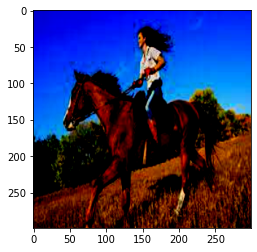

a young girl is riding a horse in a field .


In [ ]:
# Woman on horse image
print(caption_image('horse1.jpg'))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


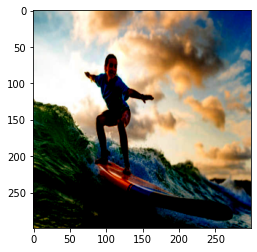

a man in a blue wetsuit is wakeboarding in a blue shirt .


In [ ]:
# Woman surfing image
print(caption_image('surfing.jpg'))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


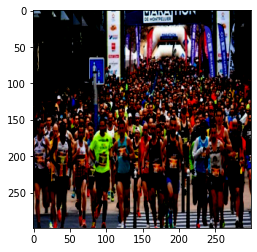

a group of people are standing on a <UNK> watching a <UNK> .


In [ ]:
# Marathon image
print(caption_image('marathon.jpg'))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


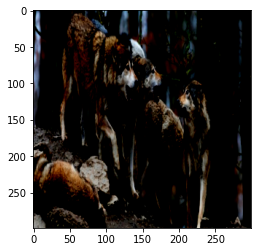

two dogs are running through the snow .


In [ ]:
# Wolves pack image
print(caption_image('wolves.jpg'))